# Importing Libraries

In [30]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Loading the data

In [33]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input/speechemotionrecognition'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


# Understanding the data

In [34]:
len(paths)

2800

In [35]:
paths[:5]


['/kaggle/input/speechemotionrecognition/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/speechemotionrecognition/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/speechemotionrecognition/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/speechemotionrecognition/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/speechemotionrecognition/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [36]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [37]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/kaggle/input/speechemotionrecognition/TESS To...,fear
1,/kaggle/input/speechemotionrecognition/TESS To...,fear
2,/kaggle/input/speechemotionrecognition/TESS To...,fear
3,/kaggle/input/speechemotionrecognition/TESS To...,fear
4,/kaggle/input/speechemotionrecognition/TESS To...,fear


In [38]:
df['label'].value_counts()

fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: label, dtype: int64

# Feature Extraction

In [39]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [40]:
extract_mfcc(df['speech'][0])

array([-285.73727   ,   85.78295   ,   -2.1689112 ,   22.125532  ,
        -14.757395  ,   11.051346  ,   12.412449  ,   -3.0002618 ,
          1.0844991 ,   11.078272  ,  -17.41966   ,   -8.093213  ,
          6.5879726 ,   -4.2209535 ,   -9.15508   ,    3.52148   ,
        -13.186381  ,   14.078853  ,   19.66973   ,   22.725618  ,
         32.57464   ,   16.325035  ,   -3.8427293 ,    0.89629656,
        -11.239262  ,    6.653462  ,   -2.5883696 ,   -7.7140164 ,
        -10.941658  ,   -2.4007547 ,   -5.281288  ,    4.271157  ,
        -11.202216  ,   -9.024621  ,   -3.6669848 ,    4.869744  ,
         -1.6027985 ,    2.5600514 ,   11.454374  ,   11.233449  ],
      dtype=float32)

In [41]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [42]:
X_mfcc

0       [-285.73727, 85.78295, -2.1689112, 22.125532, ...
1       [-348.34332, 35.193233, -3.841328, 14.658875, ...
2       [-340.11435, 53.796444, -14.267782, 20.884027,...
3       [-306.63422, 21.259708, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
2795    [-374.3952, 60.864998, 0.025059083, 8.431058, ...
2796    [-313.96478, 39.847843, -5.6493053, -3.867575,...
2797    [-357.54886, 77.886055, -15.224756, 2.194633, ...
2798    [-353.1474, 101.68391, -14.175896, -12.037376,...
2799    [-389.4595, 54.042767, 1.346998, -1.4258983, -...
Name: speech, Length: 2800, dtype: object

In [43]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

# Input splitting

In [44]:
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [72]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [73]:
y=y.toarray()

In [47]:
y.shape

(2800, 7)

# Creating LSTM model

In [74]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 7)                

# Train the model

In [75]:
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
35/35 [==============================] - 8s 155ms/step - loss: 1.0495 - accuracy: 0.6004 - val_loss: 2.6774 - val_accuracy: 0.0500
Epoch 2/50
35/35 [==============================] - 4s 124ms/step - loss: 0.4565 - accuracy: 0.8228 - val_loss: 3.2082 - val_accuracy: 0.1071
Epoch 3/50
35/35 [==============================] - 4s 120ms/step - loss: 0.2498 - accuracy: 0.9228 - val_loss: 3.0582 - val_accuracy: 0.3393
Epoch 4/50
35/35 [==============================] - 4s 120ms/step - loss: 0.1544 - accuracy: 0.9545 - val_loss: 2.3641 - val_accuracy: 0.4554
Epoch 5/50
35/35 [==============================] - 4s 120ms/step - loss: 0.1143 - accuracy: 0.9634 - val_loss: 2.2818 - val_accuracy: 0.4929
Epoch 6/50
35/35 [==============================] - 4s 118ms/step - loss: 0.1166 - accuracy: 0.9629 - val_loss: 3.4153 - val_accuracy: 0.3107
Epoch 7/50
35/35 [==============================] - 4s 118ms/step - loss: 0.1020 - accuracy: 0.9692 - val_loss: 3.3642 - val_accuracy: 0.2911
Epoch 

# Plotting

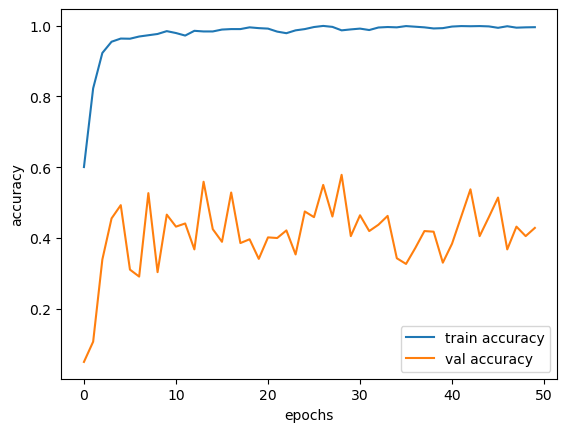

In [76]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

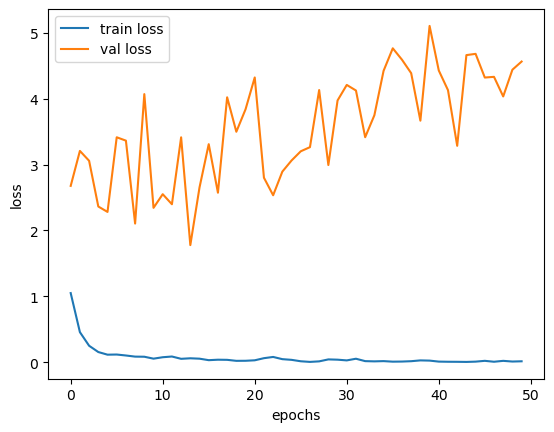

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()